In [1]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, rmsprop
from keras.layers import LSTM, GRU
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from utils.multi_gpu import make_parallel
from dataset.dataset import leer
from keras.utils.np_utils import to_categorical

### Cargar Datos
___

In [3]:
%%time
URL='data/'
Xtr,Ytr,Xt,Yt,Xv,Yv = leer(URL)
#Datos de entrenamiento
X_train = Xtr.reshape((Xtr.shape[0],32,32,3))
X_train = X_train.transpose([0, 3, 2, 1]) 
Y_train = to_categorical(Ytr, 10)
#Datos de Test
X_test  = Xt.reshape((Xt.shape[0],32,32,3))
X_test  = X_test.transpose([0, 3, 2, 1])
Y_test  = to_categorical(Yt, 10)
#Datos de Validación
X_val   = Xv.reshape((Xv.shape[0],32,32,3))
X_val   = X_val.transpose([0, 3, 2, 1])
Y_val   = to_categorical(Yv, 10)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_val   = X_val.astype('float32') # Dataset de valdiacion de tamaño 4000

CPU times: user 819 ms, sys: 629 ms, total: 1.45 s
Wall time: 1.45 s


In [4]:
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


In [5]:
_size, n_channels, n_rows, n_cols = X_train.shape
n_classes = 10

Objetivo
-----

**(g)**Una forma interesante de regularizar modelos entrenados para vision artificial consiste en “aumentar” el numero de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porque este procedimiento podrıa ayudar a mejorar el modelo. Evalue experimentalmente la conveniencia de incorporarlo.

Keras permite realizar las siguientes operaciones para aumentar el dataset:
- Sample-wise standardization.
- Feature-wise standardization.
- ZCA whitening.
- Random rotation, shifts, shear and flips.
- Dimension reordering.

Que como vemos en el codigo entregado para la experiencia, son usados segun el estandar de Keras. Asi tambien algunos no son usados como en el caso de ZCA que aplaica una funcion de whitening, con el fin de reducir la reduncacia de información en los pixeles. 

In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(X_train)

In [8]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(n_channels, n_rows, n_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 64, 16, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 8, 8)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

In [9]:
#opt  = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
opt = rmsprop(lr=0.001, decay=1e-6)

In [10]:
epochs = 25
batch_size= 400

Con el paso que viene a continuación, logramos que todas las operaciones sobre el modelo pasen de ejecutarse en una GPU, a un esquema paralelo multi-GPU. Esto se verá reflejado en los tiempos de fit, registrados en los notebook.  

In [11]:
model = make_parallel(model, 8)

/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


In [12]:
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer=opt,  metrics=['accuracy'])

In [13]:
%%time
history_categorical_crossentropy = model.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0]// batch_size,verbose=0,
                        epochs=epochs,validation_data=(X_test, Y_test))

CPU times: user 15min 13s, sys: 3min 21s, total: 18min 35s
Wall time: 5min 55s


Además de probar el uso de en “aumentar” el número de ejemplos, también se probo el uso de otro optimizador dentro de las pruebas, el optimizador Adam. Que por lo menos afecta en reducir los tiempos de entrenamiento.

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',  metrics=['accuracy'])

In [18]:
%%time
history_categorical_crossentropy_adam = model.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0]// batch_size,verbose=0,
                        epochs=epochs,validation_data=(X_test, Y_test))

CPU times: user 15min 4s, sys: 3min 15s, total: 18min 19s
Wall time: 5min 47s


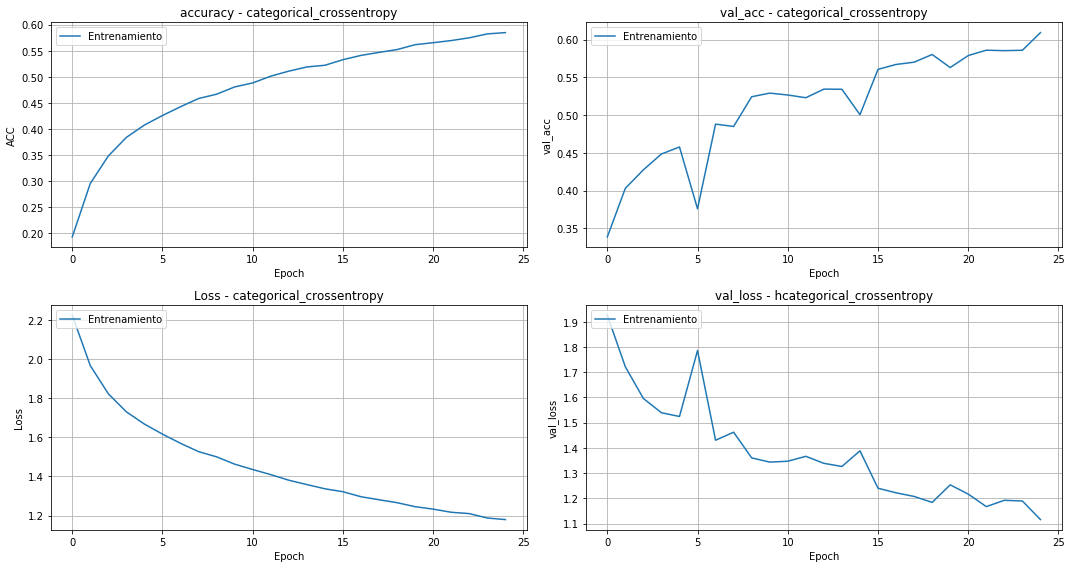

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history_categorical_crossentropy.history['acc'])  
plt.title('accuracy - categorical_crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_categorical_crossentropy.history['val_acc'])  
plt.title('val_acc - categorical_crossentropy')  
plt.ylabel('val_acc')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_categorical_crossentropy.history['loss'])  
plt.title('Loss - categorical_crossentropy')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history_categorical_crossentropy.history['val_loss'])  
plt.title('val_loss - hcategorical_crossentropy')  
plt.ylabel('val_loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Comentarios
---

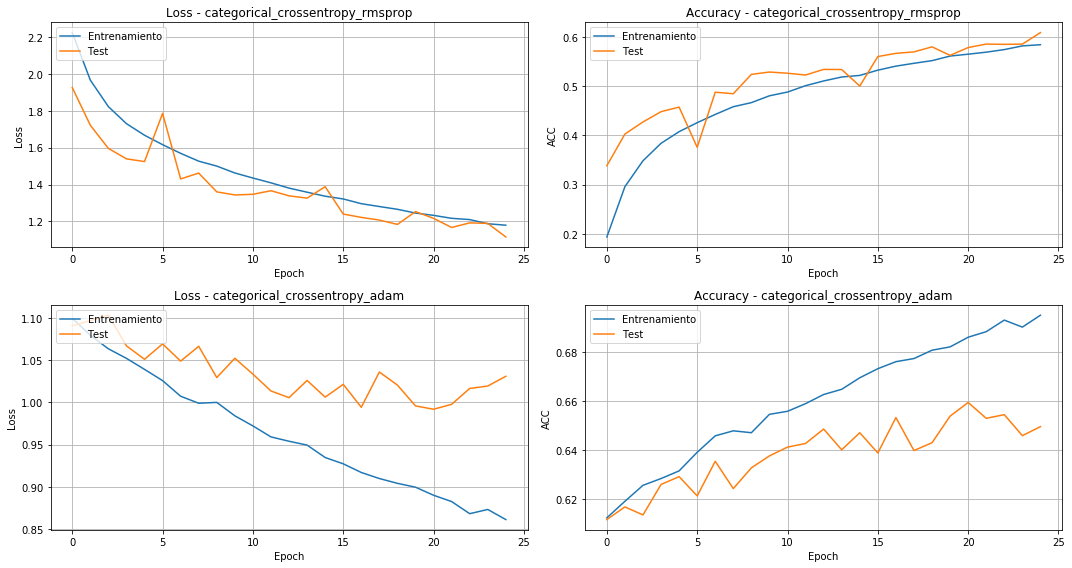

In [20]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history_categorical_crossentropy.history['loss'])  
plt.plot(history_categorical_crossentropy.history['val_loss'])  
plt.title('Loss - categorical_crossentropy_rmsprop')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_categorical_crossentropy.history['acc'])  
plt.plot(history_categorical_crossentropy.history['val_acc'])  
plt.title('Accuracy - categorical_crossentropy_rmsprop')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_categorical_crossentropy_adam.history['loss'])  
plt.plot(history_categorical_crossentropy_adam.history['val_loss'])  
plt.title('Loss - categorical_crossentropy_adam')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history_categorical_crossentropy_adam.history['acc'])  
plt.plot(history_categorical_crossentropy_adam.history['val_acc'])  
plt.title('Accuracy - categorical_crossentropy_adam')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Como podemos ver para este problema el uso del optimizador RMSProp ajusta mejor proceso de aprendizaje que Adam, obtenido la combinación RMSProp- categorical crossentropy asociado al la aplicación de la tecnica de aumento del dataset es la que presenta mejor resultados en el acurracy del modelo, pues pasamos de un 67.67 que era el mejor resultado hasta ahora, cuando reemplazamos las capas de pooling por convolucionales, a un  74.30%.

In [22]:
#%%time
scores = model.evaluate(X_val, Y_val)
print("")
print("Accuracy del modelo con rmsprop: %.2f%%" % (scores[1]*100))
print("Loss del modelo con rmsprop: %.2f%%" % (scores[0]*100))

3840/4000 [===========================>..] - ETA: 0s

In [24]:
#%%time
scores = model.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con adam: %.2f%%" % (scores[1]*100))

 9952/10000 [============================>.] - ETA: 0s

In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
